In [2]:
import os, subprocess
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker, cm
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import leastsq, root, brentq, fsolve
import tqdm

import multiprocessing
from functools import partial

import pycbc.waveform
import cosmolopy.distance as cd

from gwaxion import physics

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'serif',
    'font.size': 24,
    'font.serif': 'Computer Modern Roman'
}
matplotlib.rcParams.update(mplparams)

cosmo = {'omega_M_0':0.308, 'omega_lambda_0':0.692, 'omega_k_0':0.0, 'h':0.678}

# Horizon

To find the horizon we want to set $\rho = 1$, where
\begin{equation*}
\rho \equiv \frac{h_\oplus}{h_{\rm th}(f_\oplus)} = \left( \frac{h_0}{h_{95}} d_0\, {\rm ASD}_{95} \right) \frac{1}{d_z\, {\rm ASD}[f_0\left(1+z\right)^{-1}]}\, ,
\end{equation*}
and $h_\oplus$ and $f_\oplus$ are the GW amplitude and frequency measured at Earth, namely
\begin{align}
h_\oplus &= h_0 \frac{d_0}{d_z}\, ,\\
f_\oplus &= f_0 \left(1+z\right)^{-1}\, ,
\end{align}
with $f_0$ the source-frame GW frequency and $h_0$ the strain at luminosity distance $d_0$.

The denominator in the second factor above can be interpolated for $f_0$ and $z$.

In [3]:
def h95_viterbi(asd_f, T=None):
    # From Lilli: 95% detection efficiency h0 is 4.7e-26 at 201.2 Hz and an ASD of 4E-24 Sqrt[Hz], for T=80 days
    h95ref = 4.7E-26
    f95ref = 201.2
    asd95ref = 4E-24
    Tref = 80*physics.DAYSID_SI
    T = T if T is not None else Tref
    return h95ref * (asd_f/asd95ref) * (Tref/T)**0.25

def euclidean_horizon(h0, f=None, asd_interp=None, dref=5, T=None):
    """ Computes horizon (Mpc) assuming no redshift."""
    asd = asd_interp(f)
    h95 = h95_viterbi(asd, T=T)
    return h0 * dref / h95

def z_to_dl(z):
    return cd.luminosity_distance(z, **cosmo)

## find redshift for a given luminosity distance
def dl_to_z(dl, z0=1):
    return leastsq(lambda z: dl - cd.luminosity_distance(z, **cosmo), z0)[0]

# ## estimate the horizon for recursive evaluation in the main code
# def horizon_dist_eval(h_ratio, d0, z0):
#     guess_dist = d0*h_ratio
#     guess_redshift, res = leastsq(findzfromDL, z0, args=guess_dist)
#     return guess_redshift[0], guess_dist



In [4]:
# define h and z factors

h95ref = 4.7E-26
asd95ref = 4E-24
log_d0 = np.log10(5)
log_h95ref = np.log10(h95ref)
log_asd95ref = np.log10(asd95ref)

def log_h_factor(h0):
    log_h0 = np.log10(h0)
    return log_h0 + log_d0 + log_asd95ref - log_h95ref

def log_z_factor(f0, z, asd_interp):
    dz = cd.luminosity_distance(z, **cosmo)
    fz = f0/(1. + z)
    return np.log10(dz * asd_interp(fz))

# horizon-finding functions
def compute_log_zH_brentq(h0, f0, asd_interp, log_z_min=-10, log_z_max=2):
    try:
        log_zH = brentq(lambda log_z: log_h_factor(h0) - log_z_factor(f0, 10**log_z, asd_interp), log_z_min, log_z_max)
    except ValueError:
        log_zH = np.nan
    return log_zH
            
def compute_log_zH_leastsq(h0, f0, asd_interp, log_z_guess=0):
    log_zH = leastsq(lambda log_z: log_h_factor(h0) - log_z_factor(f0, 10**log_z, asd_interp), log_z_guess)[0]
    return log_zH

In [5]:
# find approx redshift for dL = 1 pc
print dl_to_z(1E-6)
print "%.1e pc" % (z_to_dl(2.5E-10)*1E6)

[2.26156457e-10]
1.1e+00 pc


Define functions to use with `multiprocessing`:

In [6]:
reload(physics)

<module 'gwaxion.physics' from '/home/misi/.local/lib/python2.7/site-packages/gwaxion/physics.pyc'>

In [7]:
# first, some voodoo to allow for nested multiprocesses
# see https://stackoverflow.com/questions/6974695/python-process-pool-non-daemonic

import multiprocessing
# We must import this explicitly, it is not imported by the top-level
# multiprocessing module.
import multiprocessing.pool

class NoDaemonProcess(multiprocessing.Process):
    # make 'daemon' attribute always return False
    def _get_daemon(self):
        return False
    def _set_daemon(self, value):
        pass
    daemon = property(_get_daemon, _set_daemon)

# We sub-class multiprocessing.pool.Pool instead of multiprocessing.Pool
# because the latter is only a wrapper function, not a proper class.
class MyPool(multiprocessing.pool.Pool):
    Process = NoDaemonProcess

In [16]:
NCPUS_0 = 8
NCPUS_1 = 8

def get_gws(a, lgw=2, l=1, m=1, nr=0, **kwargs): 
    cloud = physics.BosonCloud.from_parameters(l, m, nr, alpha=a, **kwargs) 
    return cloud.gw(lgw).h0r, cloud.gw(lgw).f

def scan_alphas(mbh_chi):
    mbh, chi = mbh_chi
    # construct alphas
    alpha_max = physics.get_alpha_max(chi)
    if alpha_max < 0.01:
        return [0]*2
    else:
        alphas = np.arange(0.01, alpha_max, 0.01)
        # collect peak values
        pool = multiprocessing.Pool(NCPUS_1)
        h0r_fs = pool.map(partial(get_gws, m_bh=mbh, chi_bh=chi), alphas)
        return max(h0r_fs)

def get_row(mbh_chi, distance=1):
    hrmax, fmax = scan_alphas(mbh_chi)
    mbh, chi = mbh_chi
    return {'mbh': mbh, 'chi': chi, 'h0': hrmax/distance, 'fgw': fmax}

## Source frame

Load source-frame quantities from disk, or create if not found

In [17]:
dfpath = 'peak_DE.hdf5'
rewrite = True

if os.path.exists(dfpath) and not rewrite:
    df_max = pd.read_hdf(dfpath, 'table', mode='r')
else:
    n_mass = 10
    n_chi = 10
    
    mbhs_array = np.logspace(-1, 4, n_mass)
    chis_array = np.linspace(1E-4, 1, n_chi, endpoint=False)

    distance = 5E6 * physics.PC_SI

    # create mbh_chi array
    mbh_chis = []
    for mbh in mbhs_array:
        for chi in chis_array:
            mbh_chis.append([mbh, chi])
    
    # run over Ms and chis
    pool = MyPool(NCPUS_0)
    rows = pool.map(partial(get_row, distance=distance), mbh_chis)
    df_max = pd.DataFrame(rows)
    df_max.to_hdf(dfpath, 'table', mode='w')

In [18]:
# condition data
df_cond = df_max[(df_max['fgw']>=0.01) & (df_max['fgw']<=1E6) & (df_max['h0']>1E-40)].copy()

# aLIGO design

## PSD

/home/misi/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


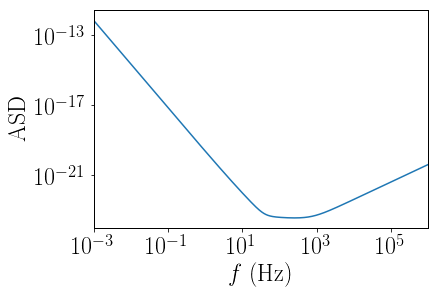

In [21]:
from lalsimulation import SimNoisePSDaLIGOZeroDetHighPower

flow = 0.001
fhig = 1E6
freqs = np.linspace(flow, fhig, int(5E6))

psd_des = np.array([SimNoisePSDaLIGOZeroDetHighPower(f) for f in freqs])
asd_des = psd_des**0.5

psd_des_interp = interp1d(freqs, psd_des)
asd_des_interp = interp1d(freqs, asd_des, bounds_error=False, fill_value=np.inf)

fig, ax = plt.subplots(1)
ax.plot(freqs, asd_des)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(flow, fhig)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)

## Diagnose horizon finders

In [31]:
# test horizon finders

%timeit log_zH_leastsq = compute_log_zH_leastsq(5E-26, 200, asd_des_interp)
log_zH_leastsq = compute_log_zH_leastsq(5E-26, 200, asd_des_interp)
print z_to_dl(10**log_zH_leastsq)

%timeit log_zH_brentq = compute_log_zH_brentq(5E-26, 200, asd_des_interp)
log_zH_brentq = compute_log_zH_brentq(5E-26, 200, asd_des_interp)
print z_to_dl(10**log_zH_leastsq)

%timeit log_zH_brentq = compute_log_zH_brentq(5E-26, 200, asd_des_interp, log_z_min=-9, log_z_max=0)
log_zH_brentq = compute_log_zH_brentq(5E-26, 200, asd_des_interp)
print z_to_dl(10**log_zH_leastsq)


100 loops, best of 3: 2.4 ms per loop
[5.86264798]
100 loops, best of 3: 2.22 ms per loop
[5.86264798]
1000 loops, best of 3: 2.29 ms per loop
[5.86264798]


In [32]:
h0_array = np.logspace(-27, -22, 50)
f0_array = np.logspace(np.log10(30), 4, 50)

# log(r) = log(h-factor) - log(z-factor) ==> want lobbg(h-factor) - log(z-factor) == 0
h0s, f0s, log_zHs = [], [], []
with tqdm.tqdm(range(len(h0_array)*len(f0_array))) as pbar:
    for h0 in h0_array:
        for f0 in f0_array:
            log_zHs.append(compute_log_zH_brentq(h0, f0, asd_des_interp))
            h0s.append(h0)
            f0s.append(f0)
            pbar.update()
            
h0s = np.array(h0s)
f0s = np.array(f0s)
log_zHs = np.array(log_zHs)

100%|██████████| 2500/2500 [00:06<00:00, 369.37it/s]


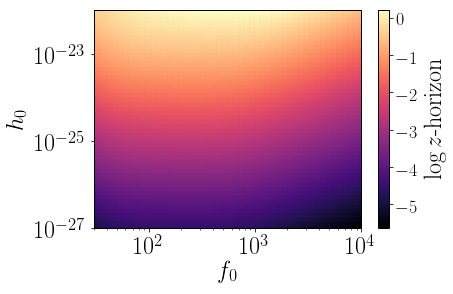

In [33]:
# diagnose interpolant data

fig, ax = plt.subplots(1)
cm = ax.scatter(f0s, h0s, c=log_zHs, cmap='magma')

# add colorbar
cb = plt.colorbar(cm, label=r'$\log z$-horizon')
cb.ax.tick_params(labelsize=18) 

plt.xlabel(r'$f_0$')
plt.ylabel(r'$h_0$')
ax.patch.set_facecolor("grey")

plt.xscale('log')
plt.yscale('log')

plt.xlim(30, 1E4)
plt.ylim(1E-27, 1E-22)

plt.show()
plt.close()

## Range

In [22]:
# log(r) = log(h-factor) - log(z-factor) ==> want lobbg(h-factor) - log(z-factor) == 0

log_zHs_des = []
with tqdm.tqdm(range(len(df_cond))) as pbar:
    for h0, f0 in zip(df_cond['h0'], df_cond['fgw']):
        log_zHs_des.append(compute_log_zH_brentq(h0, f0, asd_des_interp))
        pbar.update()        
log_zHs_des = np.array(log_zHs_des)

100%|██████████| 90/90 [00:00<00:00, 254.81it/s]


In [23]:
df_cond['log_zH_des'] = log_zHs_des
df_cond.to_hdf('peak_horizon_des_DE.hdf5', 'table', mode='w')

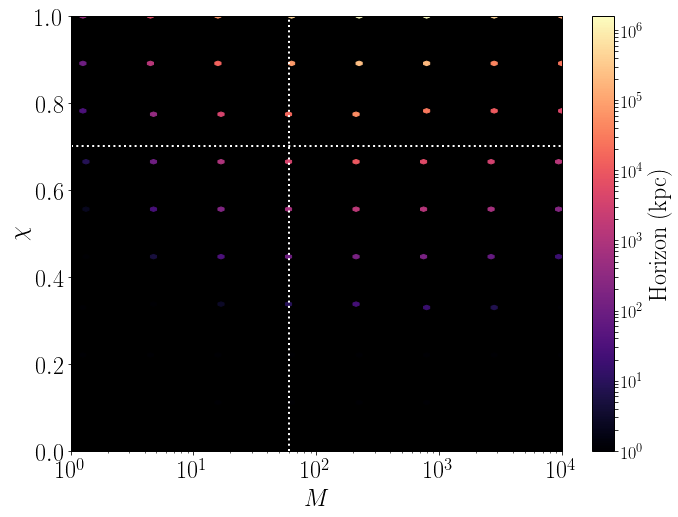

In [24]:
# plot

x = df_cond['mbh']
y = df_cond['chi']
C = z_to_dl(10**df_cond['log_zH_des'])*1E3

fig, ax = plt.subplots(1, figsize=(11,8))
norm = matplotlib.colors.LogNorm(vmin=1, vmax=C.max())
cm = ax.hexbin(x, y, C=C, cmap='magma', norm=norm, xscale='log')
cm.set_rasterized(True)

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
cb = plt.colorbar(cm, label=r'Horizon (kpc)', norm=norm)
cb.ax.tick_params(labelsize=18) 

plt.xlabel(r'$M$')
plt.ylabel(r'$\chi$')
ax.patch.set_facecolor("black")

plt.xscale('log')

ax.set_xlim(1, 1E4)
plt.ylim(0, 1)

fig.savefig('cmap_chi_mbh_range_design_DE.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

In [22]:
print "Maximum redshift: %.2e" % (10**df_cond['log_zH_des'].max())
test_z = 10**compute_log_zH_brentq(5E-26, 200, asd_des_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)
test_z = 10**compute_log_zH_leastsq(5E-26, 200, asd_des_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)

Maximum redshift: 3.73e-01
GW150914 horizon: 5.9 Mpc (z=1.3e-03)
GW150914 horizon: 5.9 Mpc (z=1.3e-03)


# Voyager

Voyager band:
6.0116914 5000.0


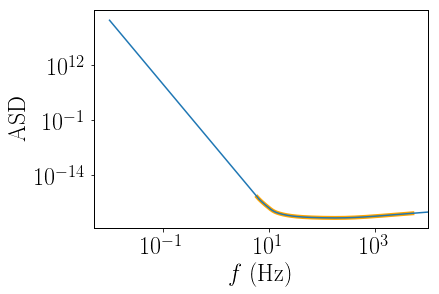

In [394]:
# load Voyager ASD
vals = np.loadtxt('noise_curves_T1500293-v10/voyager.txt')
fs, asd_voy_array = vals[:,0], vals[:,1]

# this curve has an artificial turn around 5.02 Hz so discard those points before extrapolation
f_cut = 6
asd_voy_array = asd_voy_array[fs>f_cut]
fs = fs[fs>f_cut]

print "Voyager band:"
print fs.min(), fs.max()

# create interpolant (in logspace)
log_asd_voy_interp = interp1d(np.log10(fs), np.log10(asd_voy_array), fill_value='extrapolate')
def asd_voy_interp(f): lasd=log_asd_voy_interp(np.log10(f)); return 10**lasd

fmin, fmax = 1E-2, 1E4 #freqs.min(), freqs.max()
freqs = np.logspace(np.log10(fmin), np.log10(fmax), int(1E6))

fig, ax = plt.subplots(1)
ax.plot(fs, asd_voy_array, lw=4, color='orange')
ax.plot(freqs, asd_voy_interp(freqs))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin*0.5, fmax)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)


In [395]:
# log(r) = log(h-factor) - log(z-factor) ==> want lobbg(h-factor) - log(z-factor) == 0
log_zHs_voy = []
with tqdm.tqdm(range(len(df_cond))) as pbar:
    for h0, f0 in zip(df_cond['h0'], df_cond['fgw']):
        log_zHs_voy.append(compute_log_zH_brentq(h0, f0, asd_voy_interp))
        pbar.update()        
log_zHs_voy = np.array(log_zHs_voy)

100%|██████████| 96000/96000 [05:24<00:00, 295.92it/s]


In [396]:
df_cond['log_zH_voy'] = log_zHs_voy
# df_cond.to_hdf('new_peak_horizon_voy.hdf5', 'table', mode='w')

In [397]:
x = df_cond['mbh']
y = df_cond['chi']
C = z_to_dl(10**df_cond['log_zH_voy'])
#C = np.ma.masked_array(C, y<0.5)

In [398]:
print np.nanmax(C)

2253.8808212661147


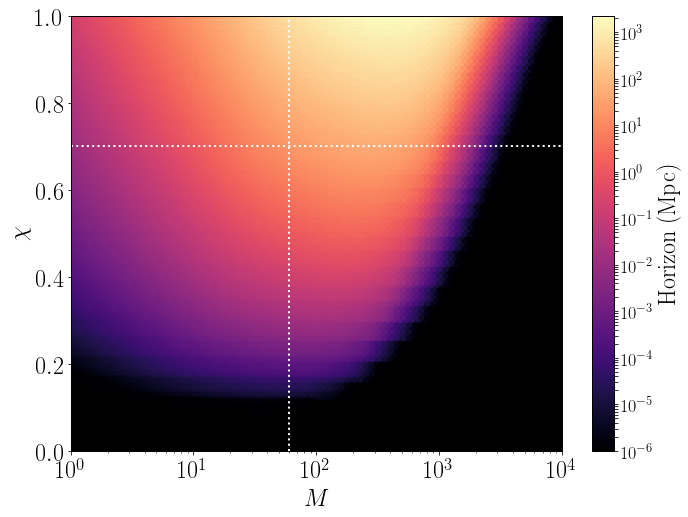

In [399]:
# plot
fig, ax = plt.subplots(1, figsize=(11,8))
cmin, cmax = 1E-6, np.nanmax(C)  # np.nanmin(C), np.nanmax(C)
norm = matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax)
cm = ax.hexbin(x, y, C=C, cmap='magma', norm=norm, xscale='log')
cm.set_rasterized(True)

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
cb = plt.colorbar(cm, label=r'Horizon (Mpc)', norm=norm)
cb.ax.tick_params(labelsize=18) 

plt.xlabel(r'$M$')
plt.ylabel(r'$\chi$')
ax.patch.set_facecolor("black")

plt.xscale('log')

ax.set_xlim(1, 1E4)
plt.ylim(0, 1)

fig.savefig('cmap_chi_mbh_range_voyage_DE.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

In [400]:
print "Maximum redshift: %.2e" % (10**df_cond['log_zH_voy'].max())
test_z = 10**compute_log_zH_brentq(4E-26, 200, asd_voy_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)
test_z = 10**compute_log_zH_leastsq(4E-26, 200, asd_voy_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)

Maximum redshift: 4.02e-01
GW150914 horizon: 20.1 Mpc (z=4.5e-03)
GW150914 horizon: 20.1 Mpc (z=4.5e-03)


# Cosmic Explorer

CE band:
5.0 5000.0


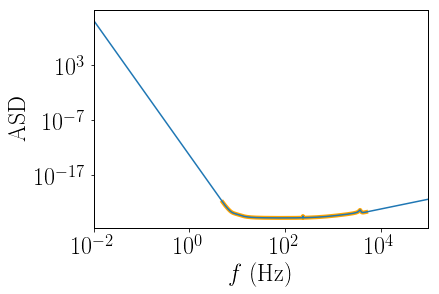

In [ ]:
# load Voyager ASD
vals = np.loadtxt('noise_curves_T1500293-v10/ce.txt')
fs, asd_ce_array = vals[:,0], vals[:,1]

print "CE band:"
print fs.min(), fs.max()

# create interpolant (in logspace)
log_asd_ce_interp = interp1d(np.log10(fs), np.log10(asd_ce_array), fill_value='extrapolate')
def asd_ce_interp(f): lasd=log_asd_ce_interp(np.log10(f)); return 10**lasd

fmin, fmax = 1E-2, 1E5 #freqs.min(), freqs.max()
freqs = np.logspace(np.log10(fmin), np.log10(fmax), int(1E6))

fig, ax = plt.subplots(1)
ax.plot(fs, asd_ce_array, lw=4, color='orange')
ax.plot(freqs, asd_ce_interp(freqs))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin, fmax)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)

In [ ]:
# log(r) = log(h-factor) - log(z-factor) ==> want lobbg(h-factor) - log(z-factor) == 0
log_zHs_ce = []
with tqdm.tqdm(range(len(df_cond))) as pbar:
    for h0, f0 in zip(df_cond['h0'], df_cond['fgw']):
        log_zHs_ce.append(compute_log_zH_brentq(h0, f0, asd_ce_interp))
        pbar.update()        
log_zHs_ce = np.array(log_zHs_ce)

 41%|████      | 39244/96000 [02:31<05:53, 160.35it/s]

In [ ]:
df_cond['log_zH_ce'] = log_zHs_ce
df_cond.to_hdf('new_peak_horizon_ce_DE.hdf5', 'table', mode='w')

In [ ]:
# plot

x = df_cond['mbh']
y = df_cond['chi']
C = z_to_dl(10**df_cond['log_zH_ce'])

fig, ax = plt.subplots(1, figsize=(11,8))
norm = matplotlib.colors.LogNorm(vmin=1E-6, vmax=np.nanmax(C))
cm = ax.hexbin(x, y, C=C, cmap='magma', norm=norm, xscale='log')
cm.set_rasterized(True)

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
cb = plt.colorbar(cm, label=r'Horizon (Mpc)', norm=norm)
cb.ax.tick_params(labelsize=18) 

plt.xlabel(r'$M$')
plt.ylabel(r'$\chi$')
ax.patch.set_facecolor("black")

plt.xscale('log')

ax.set_xlim(1, 1E4)
plt.ylim(0, 1)

fig.savefig('cmap_chi_mbh_range_ce_DE.png', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

In [ ]:
print "Maximum redshift: %.2e" % (10**df_cond['log_zH_ce'].max())
test_z = 10**compute_log_zH_brentq(4E-26, 200, asd_ce_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)
test_z = 10**compute_log_zH_leastsq(4E-26, 200, asd_ce_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)

# Einstein Telescope

In [ ]:
# load Voyager ASD
vals = np.loadtxt('noise_curves_T1500293-v10/et_d.txt')
fs, asd_et_array = vals[:,0], vals[:,1]

# this curve has an artificial turn around 1.01 Hz so discard those points before extrapolation
f_cut = 1.5
asd_et_array = asd_et_array[fs>f_cut]
fs = fs[fs>f_cut]

print "ET band:"
print fs.min(), f.max()

# create interpolant (in logspace)
log_asd_et_interp = interp1d(np.log10(fs), np.log10(asd_et_array), fill_value='extrapolate')
def asd_et_interp(f): lasd=log_asd_et_interp(np.log10(f)); return 10**lasd

fmin, fmax = 1E-2, 1E5 #freqs.min(), freqs.max()
freqs = np.logspace(np.log10(fmin), np.log10(fmax), int(1E6))

fig, ax = plt.subplots(1)
ax.plot(fs, asd_et_array, lw=4, color='orange')
ax.plot(freqs, asd_et_interp(freqs))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin, fmax)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)

In [ ]:
# log(r) = log(h-factor) - log(z-factor) ==> want lobbg(h-factor) - log(z-factor) == 0
log_zHs_et = []
with tqdm.tqdm(range(len(df_cond))) as pbar:
    for h0, f0 in zip(df_cond['h0'], df_cond['fgw']):
        log_zHs_et.append(compute_log_zH_brentq(h0, f0, asd_et_interp))
        pbar.update()        
log_zHs_et = np.array(log_zHs_et)

In [ ]:
df_cond['log_zH_et'] = log_zHs_et
df_cond.to_hdf('new_peak_horizon_et_DE.hdf5', 'table', mode='w')

In [ ]:
# plot

x = df_cond['mbh']
y = df_cond['chi']
C = z_to_dl(10**df_cond['log_zH_et'])

fig, ax = plt.subplots(1, figsize=(11,8))
norm = matplotlib.colors.LogNorm(vmin=1E-6, vmax=C.max())
cm = ax.hexbin(x, y, C=C, cmap='magma', norm=norm, xscale='log')
cm.set_rasterized(True)

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
cb = plt.colorbar(cm, label=r'Horizon (Mpc)', norm=norm)
cb.ax.tick_params(labelsize=18) 

plt.xlabel(r'$M$')
plt.ylabel(r'$\chi$')
ax.patch.set_facecolor("black")

plt.xscale('log')

ax.set_xlim(1, 1E4)
plt.ylim(0, 1)

fig.savefig('cmap_chi_mbh_range_et_DE.png', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

In [ ]:
print "Maximum redshift: %.2e" % (10**df_cond['log_zH_et'].max())
test_z = 10**compute_log_zH_brentq(4E-26, 200, asd_et_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)
test_z = 10**compute_log_zH_leastsq(4E-26, 200, asd_et_interp)
print "GW150914 horizon: %.1f Mpc (z=%.1e)" % (z_to_dl(test_z), test_z)

## Peak emission

In [ ]:
# colormap for peak h0 vs chi vs M

h0s = df_cond['h0']
hmax_ma = np.ma.masked_array(h0s, mask=(h0s<=0))

hmin, hmax = 1E-30, hmax_ma.max()
norm = matplotlib.colors.LogNorm(vmin=hmin, vmax=hmax)

fig, ax = plt.subplots(1, figsize=(11,8))

# plot contours
cm = ax.hexbin(df_cond['mbh'], df_cond['chi'], C=hmax_ma, cmap='magma', norm=norm,  xscale='log')

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'Peak $h_0$ (5 Mpc)')#, ticks=cb_ticks)
cb.ax.tick_params(labelsize=18) 

plt.ylabel(r'$\chi$')
plt.xlabel(r'$M$ $(M_\odot)$')
ax.patch.set_facecolor("black")

#plt.xlim(1, 1E4)
ax.set_xlim(1, 1E4)
plt.ylim(0, 1)

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)

cm.set_rasterized(True)

fig.savefig('cmap_chi_mbh_h0_DE.png', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

# PSD and h95's

In [ ]:
# use Voyager frequency array for the x-axis

year = 365*physics.DAYSID_SI

freqs = np.logspace(np.log10(5), 4, int(1E5))

fig, ax = plt.subplots(1, figsize=(11,8))
ax.plot(freqs, h95_viterbi(asd_des_interp(freqs)), label="aLIGO design (80 days)", lw=3, c='gray', ls='--')
ax.plot(freqs, h95_viterbi(asd_des_interp(freqs), T=year), label="aLIGO design (1 yr)", lw=3, c='gray')
ax.plot(freqs, h95_viterbi(asd_voy_interp(freqs), T=year), label="Voyager (1 yr)", lw=3, c='orange')
ax.plot(freqs, h95_viterbi(asd_ce_interp(freqs), T=year), label="Cosmic Explorer (1 yr)", lw=3, c='indigo')
ax.plot(freqs, h95_viterbi(asd_et_interp(freqs), T=year), label="Einstein Telescope (1 yr)", lw=3, c='crimson')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(freqs.min(), freqs.max())
ax.set_ylim(1E-27, 1E-22)

ax.set_xlabel(r'$f_{\rm GW}$ (Hz)')
ax.set_ylabel(r'$h^{95\%}_0$')

ax.legend(loc='best', fontsize=22)

fig.savefig('plot_h095_fgw.png', bbox_inches='tight')

plt.show(fig)
plt.close()